In [1]:
!pip install git+https://github.com/waltsims/k-wave-python

import numpy as np
import scipy.io
from matplotlib import pyplot as plt
from copy import deepcopy

from kwave.data import Vector
from kwave.kgrid import kWaveGrid
from kwave.kmedium import kWaveMedium
from kwave.kspaceFirstOrder3D import kspaceFirstOrder3D
from kwave.ktransducer import NotATransducer, kWaveTransducerSimple
from kwave.options.simulation_execution_options import SimulationExecutionOptions
from kwave.options.simulation_options import SimulationOptions
from kwave.utils.dotdictionary import dotdict
from kwave.utils.signals import tone_burst, get_win
from kwave.utils.filters import gaussian_filter
from kwave.utils.conversion import db2neper
from kwave.reconstruction.tools import log_compression
from kwave.reconstruction.beamform import envelope_detection, scan_conversion
from kwave.utils.mapgen import make_ball

  Cloning https://github.com/waltsims/k-wave-python to /tmp/pip-req-build-fjcsfs3j
  Running command git clone --filter=blob:none --quiet https://github.com/waltsims/k-wave-python /tmp/pip-req-build-fjcsfs3j
  Resolved https://github.com/waltsims/k-wave-python to commit d8f56f34eea9d1e68f72bce3708a9fc55f2fb71f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.1/819.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.6/76.6 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 40.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 19.5 MB/s eta 0:00:00
  Created wheel for k-Wave-python: filename=k_wave_python-0.3.2-py3-no

In [2]:
# simulation settings
DATA_CAST = 'single'
RUN_SIMULATION = True

In [3]:
pml_size_points = Vector([15, 10, 10])  # [grid points]
grid_size_points = Vector([256, 256, 128]) - 2 * pml_size_points  # [grid points]
grid_size_meters = 50e-3  # [m]
grid_spacing_meters = grid_size_meters / Vector([grid_size_points.x, grid_size_points.x, grid_size_points.x])

c0 = 1540
rho0 = 1000

medium = kWaveMedium(
    sound_speed=None,  # will be set later
    alpha_coeff=0.75,
    alpha_power=1.5,
    BonA=6
)

In [4]:
kgrid = kWaveGrid(grid_size_points, grid_spacing_meters)
t_end = (grid_size_points.x * grid_spacing_meters.x) * 2.2 / c0  # [s]
kgrid.makeTime(c0, t_end=t_end)

(Vector([[0.00000000e+00, 4.30984944e-08, 8.61969889e-08, ...,
          7.13280083e-05, 7.13711068e-05, 7.14142053e-05]]),
 Vector(4.30984944e-08))

In [5]:
source_strength = 1e6  # [Pa]
tone_burst_freq = 1e6  # [Hz]
tone_burst_cycles = 4

input_signal = tone_burst(1 / kgrid.dt, tone_burst_freq, tone_burst_cycles)
input_signal = (source_strength / (c0 * rho0)) * input_signal

In [6]:
transducer = dotdict()
transducer.number_elements = 64  # total number of transducer elements
transducer.element_width = 1  # width of each element [grid points/voxels]
transducer.element_length = 40  # length of each element [grid points/voxels]
transducer.element_spacing = 0  # spacing (kerf  width) between the elements [grid points/voxels]
transducer.radius = float('inf')  # radius of curvature of the transducer [m]

# calculate the width of the transducer in grid points
transducer_width = transducer.number_elements * transducer.element_width + (
        transducer.number_elements - 1) * transducer.element_spacing

# use this to position the transducer in the middle of the computational grid
transducer.position = np.round([
    1,
    grid_size_points.y / 2 - transducer_width / 2,
    grid_size_points.z / 2 - transducer.element_length / 2
])
transducer = kWaveTransducerSimple(kgrid, **transducer)

In [7]:
not_transducer = dotdict()
not_transducer.sound_speed = c0  # sound speed [m/s]
not_transducer.focus_distance = 30e-3  # focus distance [m]
not_transducer.elevation_focus_distance = 30e-3  # focus distance in the elevation plane [m]
not_transducer.steering_angle = 0  # steering angle [degrees]
not_transducer.steering_angle_max = 32  # steering angle [degrees]
not_transducer.transmit_apodization = 'Hanning'
not_transducer.receive_apodization = 'Rectangular'
not_transducer.active_elements = np.ones((transducer.number_elements, 1))
not_transducer.input_signal = input_signal

not_transducer = NotATransducer(transducer, kgrid, **not_transducer)

In [8]:
# Define a random distribution of scatterers for the medium
background_map_mean = 1
background_map_std = 0.008
background_map = background_map_mean + background_map_std * np.random.randn(kgrid.Nx, kgrid.Ny, kgrid.Nz)

sound_speed_map = c0 * background_map
density_map = rho0 * background_map

In [9]:
# Define a random distribution of scatterers for the highly scattering region
scattering_map = np.random.randn(kgrid.Nx, kgrid.Ny, kgrid.Nz)
scattering_c0 = np.clip(c0 + 25 + 75 * scattering_map, 1400, 1600)
scattering_rho0 = scattering_c0 / 1.5

In [10]:
# Define a sphere for a highly scattering region
radius = 8e-3
x_pos = 32e-3
y_pos = kgrid.dy * kgrid.Ny / 2
z_pos = kgrid.dz * kgrid.Nz / 2
ball_center = np.round(Vector([x_pos, y_pos, z_pos]) / kgrid.dx)
scattering_region1 = make_ball(grid_size_points, ball_center, round(radius / kgrid.dx)).nonzero()

sound_speed_map[scattering_region1] = scattering_c0[scattering_region1]
density_map[scattering_region1] = scattering_rho0[scattering_region1]

medium.sound_speed = sound_speed_map
medium.density = density_map

In [11]:
# Range of steering angles to test
steering_angles = np.arange(-32, 32, 2)

# Preallocate the storage
number_scan_lines = len(steering_angles)
scan_lines = np.zeros((number_scan_lines, kgrid.Nt))

if RUN_SIMULATION:
    for angle_index in range(number_scan_lines):
        print(f'Computing scan line {angle_index} of {number_scan_lines}')

        # set the input settings
        input_filename = f'example_input_{angle_index}.h5'
        # set the input settings
        simulation_options = SimulationOptions(
            pml_inside=False,
            pml_size=pml_size_points,
            data_cast=DATA_CAST,
            data_recast=True,
            save_to_disk=True,
            input_filename=input_filename,
            save_to_disk_exit=False
        )

        # Update the current steering angle
        not_transducer.steering_angle = steering_angles[angle_index]

        sensor_data = kspaceFirstOrder3D(
            medium=deepcopy(medium),  # Medium is altered in-place in this function
            kgrid=kgrid,
            source=not_transducer,
            sensor=not_transducer,
            simulation_options=simulation_options,
            execution_options=SimulationExecutionOptions(is_gpu_simulation=True)
        )

        scan_lines[angle_index, :] = not_transducer.scan_line(not_transducer.combine_sensor_data(sensor_data['p'].T))

    scipy.io.savemat('example_us_phased_array_scan_lines.mat', {'scan_lines': scan_lines})
else:
    scan_lines = scipy.io.loadmat('example_us_phased_array_scan_lines')['scan_lines']


Computing scan line 0 of 32


┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

┌───────────────────────────────────────────────────────────────┐
│                  kspaceFirstOrder-CUDA v1.3                   │
├───────────────────────────────────────────────────────────────┤
│ Reading simulation configuration:                        Done │
│ Selected GPU device id:                                     0 │
│ GPU device name:                                     Tesla T4 │
│ Number of CPU threads:                                      2 │
│ Processor name:                Intel(R) Xeon(R) CPU @ 2.20GHz │
├───────────────────────────────────────────────────────────────┤
│                      Simulation details                       │
├───────────────────────────────────────────────────────────────┤
│ Domain dimensions:                            256 x 256 x 128 │
│ Medium type:                                               3D │
│ Simulation time steps:                                   1658 │
├───────────────────────────────────────────────────────────────┤
│         

In [12]:
# Trim the delay offset from the scan line data
tukey_win, _ = get_win(kgrid.Nt * 2, 'Tukey', False, 0.05)
transmit_len = len(input_signal.squeeze())
scan_line_win = np.concatenate((np.zeros([1, transmit_len * 2]), tukey_win.T[:, :kgrid.Nt - transmit_len * 2]), axis=1)

scan_lines = scan_lines * scan_line_win

# store intermediate results
scan_lines_no_input = scan_lines[len(scan_lines) // 2, :]

Nt = kgrid.Nt

In [13]:
# Create radius variable
r = c0 * np.arange(1, Nt + 1) * kgrid.dt / 2

# Define absorption value and convert to correct units
tgc_alpha_db_cm = medium.alpha_coeff * (tone_burst_freq * 1e-6)**medium.alpha_power
tgc_alpha_np_m = db2neper(tgc_alpha_db_cm) * 100

# Create time gain compensation function
tgc = np.exp(tgc_alpha_np_m * 2 * r)

# Apply the time gain compensation to each of the scan lines
scan_lines *= tgc

In [14]:
scan_lines_fund = gaussian_filter(scan_lines, 1/kgrid.dt, tone_burst_freq, 100)
scan_lines_harm = gaussian_filter(scan_lines, 1/kgrid.dt, 2 * tone_burst_freq, 30)

In [15]:
scan_lines_fund = envelope_detection(scan_lines_fund)
scan_lines_harm = envelope_detection(scan_lines_harm)

In [16]:
compression_ratio = 3
scan_lines_fund = log_compression(scan_lines_fund, compression_ratio, True)
scan_lines_harm = log_compression(scan_lines_harm, compression_ratio, True)

In [17]:
image_size = [kgrid.Nx * kgrid.dx, kgrid.Ny * kgrid.dy]
image_res = [256, 256]

b_mode_fund = scan_conversion(scan_lines_fund, steering_angles, image_size, c0, kgrid.dt, image_res)
b_mode_harm = scan_conversion(scan_lines_harm, steering_angles, image_size, c0, kgrid.dt, image_res)

In [18]:
# Create the axis variables
x_axis = [0, image_size[0] * 1e3] # [mm]
y_axis = [0, image_size[1] * 1e3]  # [mm]

Text(0.5, 1.0, 'B-Mode Image')

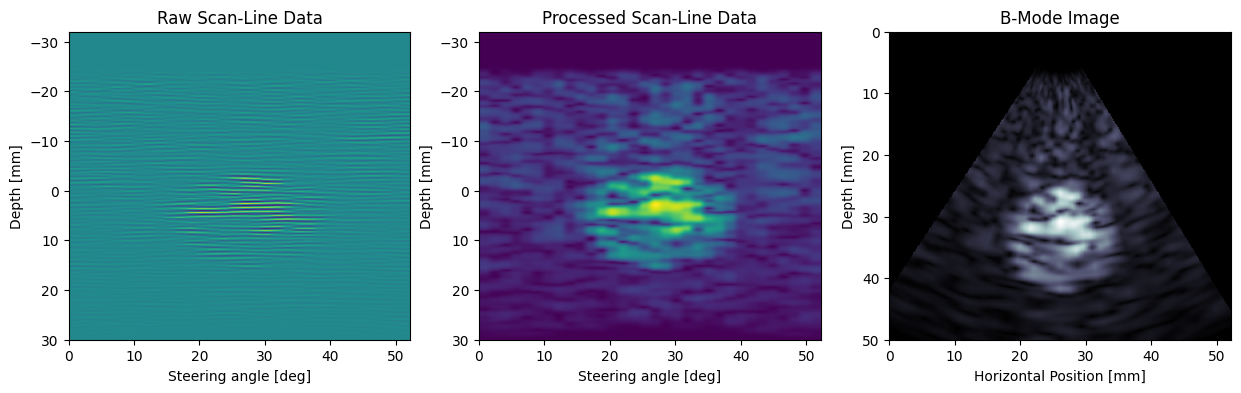

In [19]:
plt.ion()
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(scan_lines.T, aspect='auto',
            extent=[y_axis[0], y_axis[1], steering_angles[-1], steering_angles[0]])
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Raw Scan-Line Data')


plt.subplot(132)
plt.imshow(scan_lines_fund.T, aspect='auto',
            extent=[y_axis[0], y_axis[1], steering_angles[-1], steering_angles[0]])
plt.xlabel('Steering angle [deg]')
plt.ylabel('Depth [mm]')
plt.title('Processed Scan-Line Data')

plt.subplot(133)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

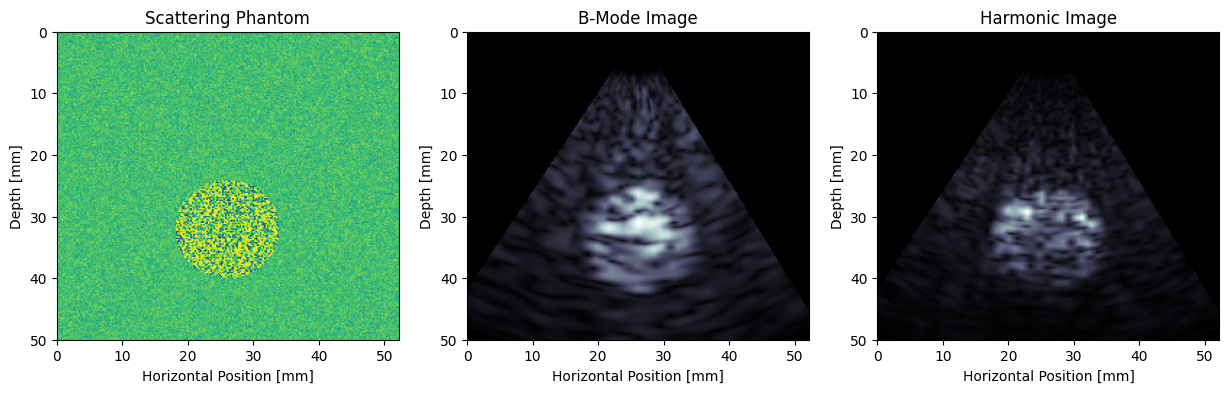

In [20]:
plt.figure(figsize=(15, 4))
plt.subplot(131)
plt.imshow(medium.sound_speed[..., kgrid.Nz//2], aspect='auto',
            extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Scattering Phantom')

plt.subplot(132)
plt.imshow(b_mode_fund, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('B-Mode Image')

plt.subplot(133)
plt.imshow(b_mode_harm, cmap='bone', aspect='auto',  extent=[y_axis[0], y_axis[1], x_axis[1], x_axis[0]])
plt.xlabel('Horizontal Position [mm]')
plt.ylabel('Depth [mm]')
plt.title('Harmonic Image')

plt.show()
